<a href="https://colab.research.google.com/github/carlottaviappiani/MLPNS_CViappiani/blob/main/convNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [3]:
plt.rcParams['figure.figsize']=[10,8] 
#vorrò plottare matrici di immagini
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gist_gray' #mappa bianco e nero per le immagini

In [4]:
cd /content/drive/MyDrive/MLPNS2023

/content/drive/MyDrive/MLPNS2023


In [5]:
ls

gender_submission.csv  spm/                          titanic.zip
kaggleTitanic/         spm-20210427T111354Z-001.zip  train.csv
model.png              test.csv                      wine.data


In [6]:
!unzip spm-20210427T111354Z-001.zip 

Archive:  spm-20210427T111354Z-001.zip
replace spm/spm_struct_pos.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace spm/spm_struct_neg.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace spm/test_good_all.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace spm/train_good_all.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace spm/test_bad_all.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace spm/train_bad_all.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [7]:
#devo leggere numpy array salvati come tali devo usare np.load (per salvarli invece np.save)
data=np.load('spm/train_good_all.npy')

In [8]:
data.shape

(1302, 64, 64)

In [9]:
#1302 immagini ognuna 64x64

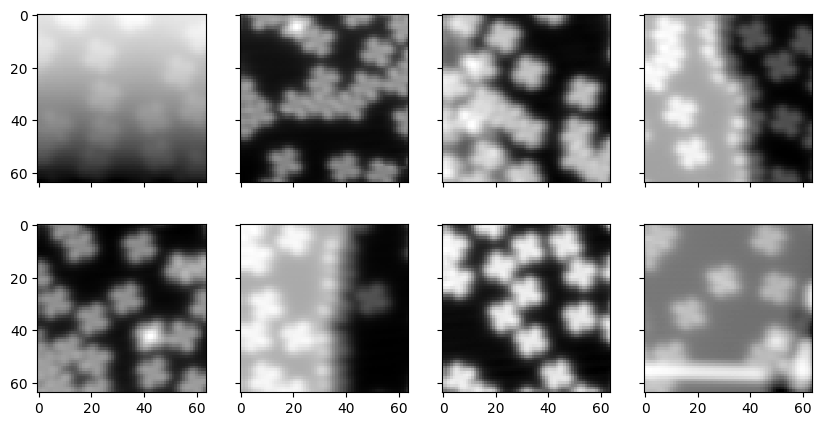

In [10]:
fig,ax=plt.subplots(2,4,figsize=[10,5],sharex=True,sharey=True)
for ii in range(8):
  ax[ii//4, ii%4].imshow(data[ii])
  #per vedere come scegliere i ii dell'ax da plottare basta fare preliminarmente ax.shape

In [11]:
#un convolution neural network impara le weight maps (ovvero le 'forme' importanti)

In [12]:
plt.hist(data.flatte())

AttributeError: ignored

In [13]:
#normalizzo dati: 
#norm_data=(data-min(data))/range(data)
norm = (data - data.min(axis=(1, 2), keepdims=True)) / (data.max(axis=(1, 2), keepdims=True) - 
                                                        data.min(axis=(1, 2), keepdims=True))

In [14]:
norm.shape

(1302, 64, 64)

In [15]:
norm.min(),norm.max()

(0.0, 1.0)

In [16]:
pos=np.load('spm/spm_struct_pos.npy')
neg=np.load('spm/spm_struct_neg.npy')

In [17]:
pos.shape, neg.shape

((500, 3), (500, 3))

In [18]:
pos[0]

array([30, 25, 51])

In [19]:
#posizioni lungo x, y e numero immagini
#quindi la prima immagine è la numero 51

In [20]:
pos.max(axis=0)

array([  62,   62, 1300])

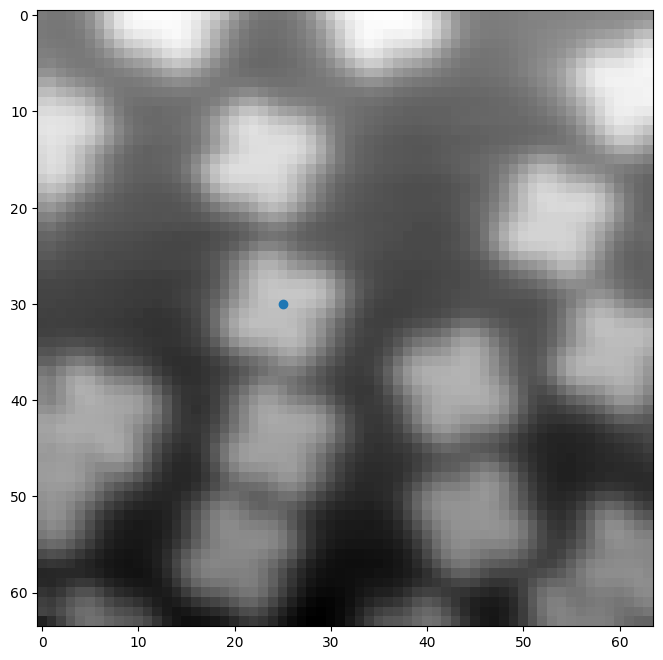

In [21]:
plt.imshow(norm[pos[0][2]])
plt.plot(pos[0][1],pos[0][0],'o') #asse x è il primo quindi [0](numero immagine)[1](asse x), y la seconda 

In [22]:
#creo input dataset di immagini con solo la molecola e di immagini che non la contengono
#poi faccio si che il neural netowrk capisca dove c'è e non c'è la molecola: creo francobolli
#cioè riquadri della molecola attorno alla posizione che ha la molecola

In [23]:
wid=10 #dalle immagini posso pensare di fare francobolli di circa 20: quindi setto come hyperparameter la mezza larghezza 
stmp_pos=[]
#creo dataset con solo molecola 
for ii in range(pos.shape[0]):
  trow,tcol,tind=pos[ii] #trow=indice sulla colonna (lungo y), trow=indice riga (lungo x), tind=indice
  if (trow>wid)&(trow<64-wid)&(tcol>wid)&(tcol<64-wid):
    stmp_pos.append(norm[tind, trow-wid:trow+wid,tcol-wid:tcol+wid])
stmp_pos=np.array(stmp_pos)

In [24]:
stmp_pos.shape

(389, 20, 20)

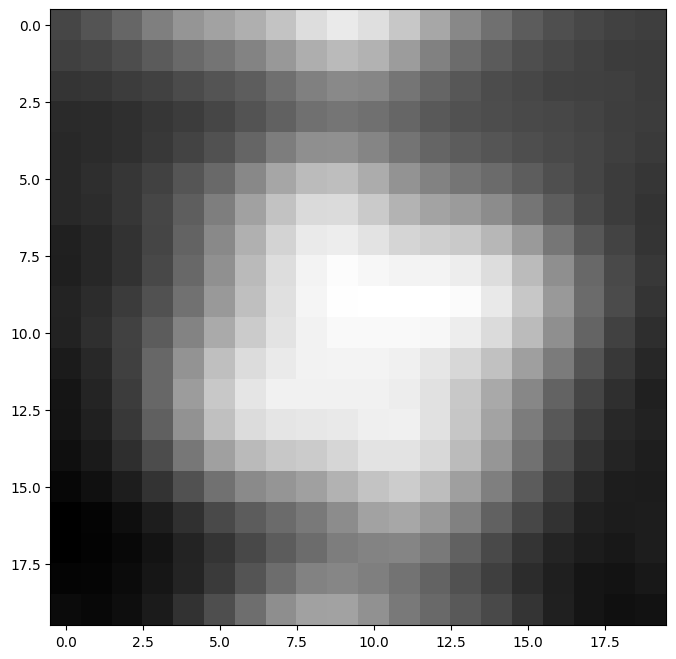

In [25]:
plt.imshow(stmp_pos[0])

In [26]:
#creo dataset con le immagini senza molecola

In [27]:
wid=10 #dalle immagini posso pensare di fare francobolli di circa 20: quindi setto come hyperparameter la mezza larghezza 
stmp_neg=[]
#creo dataset con solo molecola 
for ii in range(neg.shape[0]):
  trow,tcol,tind=neg[ii] #trow=indice sulla colonna (lungo y), trow=indice riga (lungo x), tind=indice
  if (trow>wid)&(trow<64-wid)&(tcol>wid)&(tcol<64-wid):
    stmp_neg.append(norm[tind, trow-wid:trow+wid,tcol-wid:tcol+wid])
stmp_neg=np.array(stmp_neg)

In [28]:
stmp_neg.shape

(485, 20, 20)

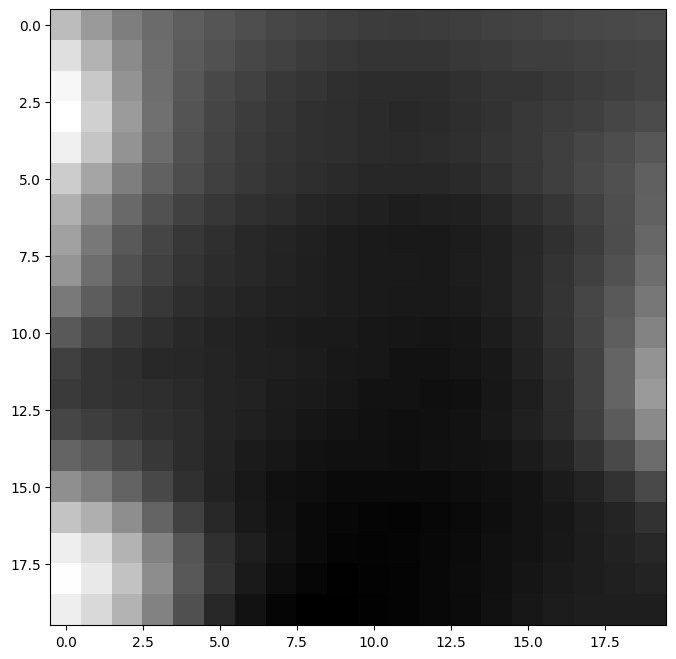

In [29]:
plt.imshow(stmp_neg[0])

In [30]:
#visualizzo immagini con la molecola (positive-pos)

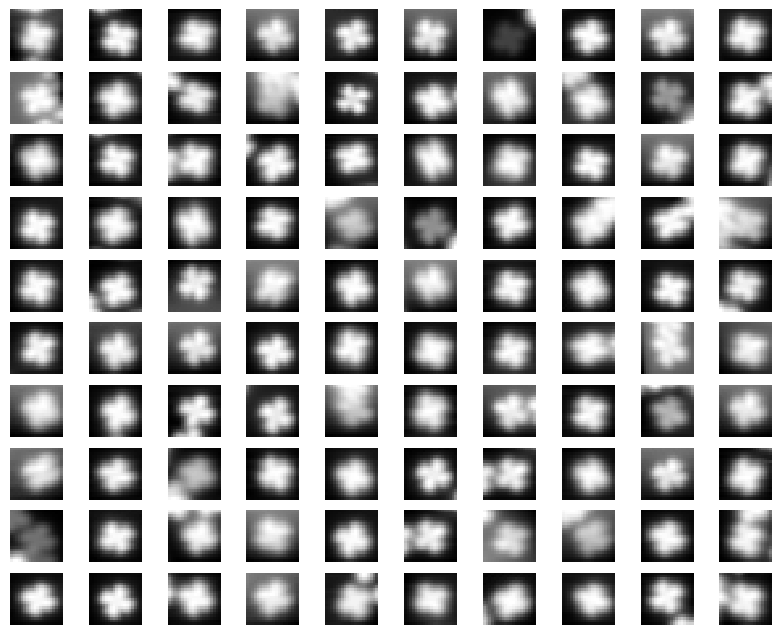

In [31]:
fig, ax = plt.subplots(10, 10)
for ii in range(100):
    ax[ii // 10, ii % 10].imshow(stmp_pos[ii])
    ax[ii // 10, ii % 10].axis("off")

In [32]:
#e quelle senza (negative)

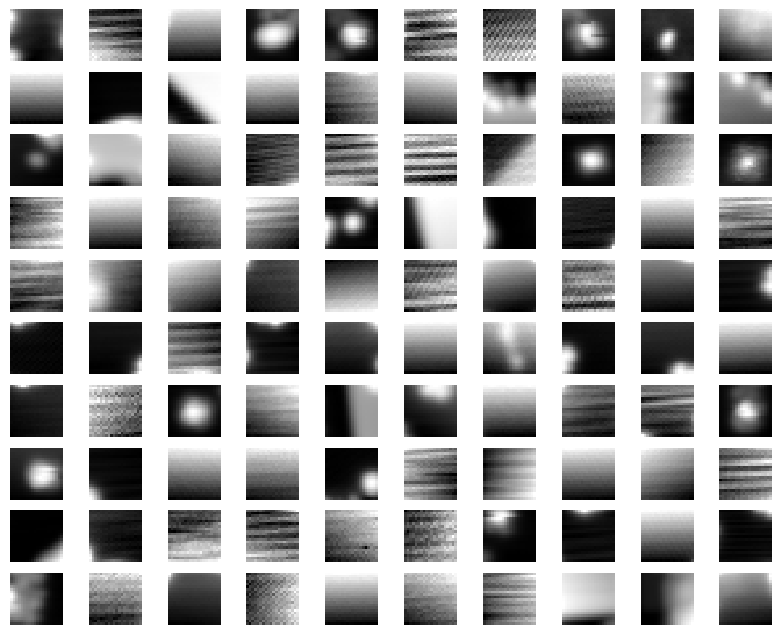

In [33]:
fig, ax = plt.subplots(10, 10)
for ii in range(100):
    ax[ii // 10, ii % 10].imshow(stmp_neg[ii])
    ax[ii // 10, ii % 10].axis("off")

In [34]:
#concateno rispettivamente tutti i neg e i pos

In [35]:
feat = np.concatenate((stmp_neg, stmp_pos), axis=0)
targ = np.concatenate((np.zeros(stmp_neg.shape[0]), 
                      np.ones(stmp_pos.shape[0])))

In [36]:
feat.shape

(874, 20, 20)

In [37]:
targ.shape

(874,)

In [38]:
#splitto entrambi i due dataset neg e pos in test e train sets

In [39]:
feat_tr, feat_te, targ_tr, targ_te = train_test_split(feat,targ,random_state=302,shuffle=True) 
#devo avere uguale numero pos e neg perchè sia ottimale: qui sono simili quindi ok

In [40]:
feat_tr.shape

(655, 20, 20)

In [41]:
#aggiungo 1 asse perchè poi la funzione che devo usare mi chiede una terza dimensione

In [42]:
feat_tr=np.expand_dims(feat_tr,axis=3)
feat_te=np.expand_dims(feat_te,axis=3)
feat_tr.shape

(655, 20, 20, 1)

Create NN con i layers:
1. conv2d 16 neurons
2. maxpool2d
3. conv2d 32 neurons
4. maxpool 2d
5. flatten
6. dense 64x64
7. dense 2 neurons

In [43]:
#kernel è il quadrato su cui faccio convoluzione 
#quindi hyperpar. è la dim del kernel, impara i numeri (i pixel) nei quadratini del kernel 

layer1 = keras.layers.Conv2D(16, kernel_size=(5, 5), padding="same", 
                             activation="relu", 
                             input_shape=(2 * wid, 2 * wid, 1), #needed in the first layer only
                             kernel_regularizer=keras.regularizers.l2(0.001))

layer2 = keras.layers.MaxPool2D(2)
layer3 = keras.layers.Conv2D(32, kernel_size=(5, 5), padding="same", 
                             activation="relu", 
                             kernel_regularizer=keras.regularizers.l2(0.001))
layer4 = keras.layers.MaxPool2D(2)
layer5 = keras.layers.Flatten()
layer6 = keras.layers.Dense(64, activation="relu",
                            kernel_regularizer=keras.regularizers.l2(0.001))
layer7 = keras.layers.Dense(2, activation="softmax")

layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7]
model = keras.Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 64)                5

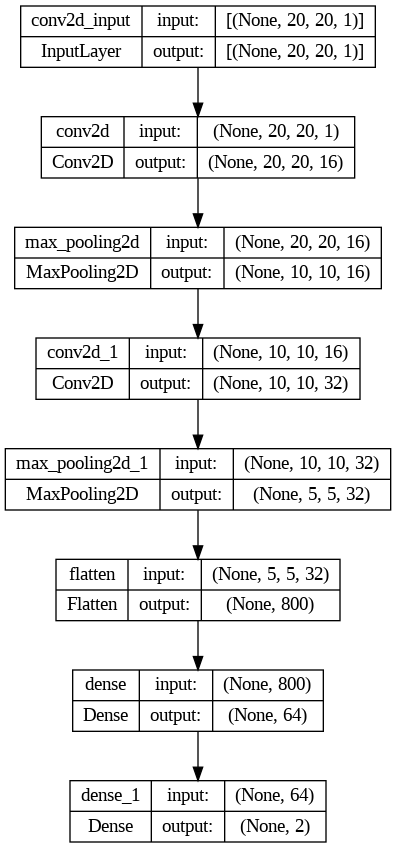

In [44]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [45]:
#compilo il modello: qui sto classificando (nell'altro notebook regression) quindi voglio loss function categorica

In [46]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

In [47]:
#model fit

In [48]:
history=model.fit(feat_tr,targ_tr,epochs=50,batch_size=50,validation_split=0.1)

Epoch 1/50
12/12 [==============================] - 3s 104ms/step - loss: 0.7150 - accuracy: 0.7997 - val_loss: 0.5549 - val_accuracy: 0.9091
Epoch 2/50
12/12 [==============================] - 1s 55ms/step - loss: 0.4889 - accuracy: 0.9015 - val_loss: 0.4050 - val_accuracy: 0.8030
Epoch 3/50
12/12 [==============================] - 0s 37ms/step - loss: 0.3650 - accuracy: 0.9049 - val_loss: 0.3448 - val_accuracy: 0.8788
Epoch 4/50
12/12 [==============================] - 0s 36ms/step - loss: 0.3356 - accuracy: 0.8998 - val_loss: 0.3681 - val_accuracy: 0.8939
Epoch 5/50
12/12 [==============================] - 0s 38ms/step - loss: 0.3003 - accuracy: 0.9185 - val_loss: 0.3723 - val_accuracy: 0.8939
Epoch 6/50
12/12 [==============================] - 0s 35ms/step - loss: 0.2655 - accuracy: 0.9304 - val_loss: 0.2705 - val_accuracy: 0.9091
Epoch 7/50
12/12 [==============================] - 0s 35ms/step - loss: 0.2310 - accuracy: 0.9423 - val_loss: 0.2390 - val_accuracy: 0.9091
Epoch 8/50
1

In [49]:
history.history['val_accuracy']

[0.9090909361839294,
 0.8030303120613098,
 0.8787878751754761,
 0.8939393758773804,
 0.8939393758773804,
 0.9090909361839294,
 0.9090909361839294,
 0.939393937587738,
 0.939393937587738,
 0.9545454382896423,
 0.9545454382896423,
 0.9545454382896423,
 0.9545454382896423,
 0.939393937587738,
 0.939393937587738,
 0.9696969985961914,
 0.939393937587738,
 0.9545454382896423,
 0.939393937587738,
 0.939393937587738,
 0.9696969985961914,
 0.9696969985961914,
 0.9545454382896423,
 0.9545454382896423,
 0.9545454382896423,
 0.9696969985961914,
 0.9545454382896423,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.939393937587738,
 0.9545454382896423,
 0.9545454382896423,
 0.9696969985961914,
 0.9545454382896423,
 0.9696969985961914,
 0.9848484992980957,
 0.9696969985961914,
 0.9696969985961914,
 0.9545454382896423,
 0.9545454382896423,
 0.9242424368858337,
 0.939393937587738,
 0.939393937587738,
 0.9545454382896423,
 0.9545454382896423,
 0.9696969985961914,
 0.9545454382896423,
 0

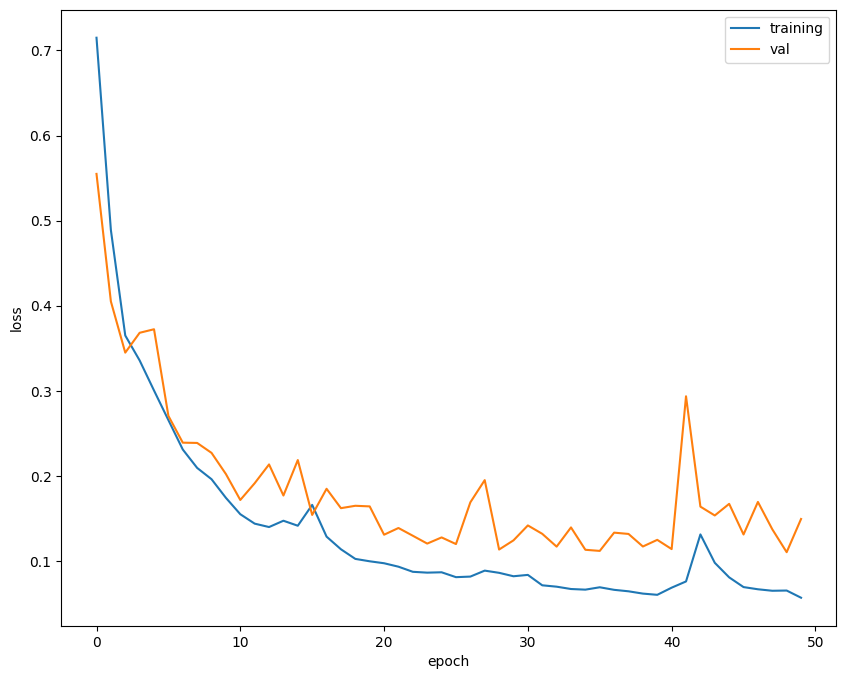

In [50]:
plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [51]:
#Vedo che c'è leggero overfitting (training a un certo punto va sotto validation) ma non significativo perchè distanza
#resta abbastanza costante. C'è però noise nelle curve, potrei diminuire learning rate 

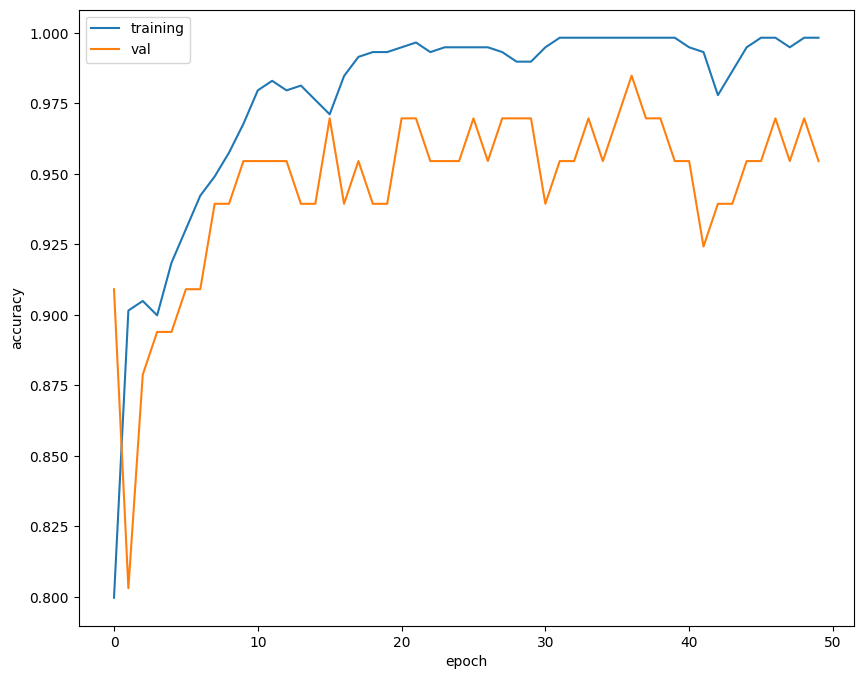

In [52]:
plt.plot(history.history['accuracy'],label='training')
plt.plot(history.history['val_accuracy'],label='val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

In [53]:
#accuratezza trainibg e testing

In [54]:
loss_tr,acc_tr=model.evaluate(feat_tr,targ_tr)
loss_te,acc_te=model.evaluate(feat_te,targ_te)
print('{:.2f},{:.2f},{:.2f},{:.2f}'.format(loss_tr,acc_tr,loss_te,acc_te))

7/7 [==============================] - 0s 10ms/step - loss: 0.1344 - accuracy: 0.9772
0.07,0.99,0.13,0.98


In [55]:
#così gli faccio imparare immagini dove c'è o non c'è l'ogetto quindi può capire se gli do un immagine se la molecola c'è o no
#Ora voglio far si che trovi la posizione della particella oltre che capire se c'è o no, cioè definirne il centro
#nell'immagine di input che gli do

In [ ]:
#scannerizzo l'immagine in cui voglio capire se c'è immagine

In [56]:
pos[0]

array([30, 25, 51])

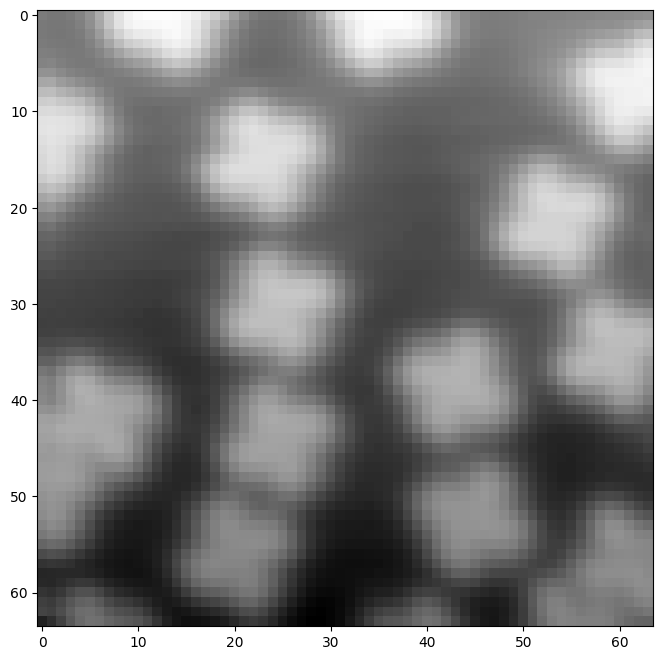

In [57]:
plt.imshow(norm[51])

In [58]:
#creo copia immagine per evitare di danneggiare l'originale
img=norm[51].copy()

In [63]:
#creo gli stamps cioè le finestre che faccio scorrere sull'immagine per scannerizzarla
nrow,ncol=img.shape
stamps=np.zeros(((nrow-wid*2)*(ncol-wid*2),2*wid,2*wid))
stamps.shape

kk=0 #index che aumenta di 1 per ogni immmagine che creo 
for ii in range(wid,nrow-wid): #rows
  for jj in range(wid,ncol-wid): #cols
    stamps[kk]=img[ii-wid:ii+wid,jj-wid:jj+wid]
    kk+=1
feat_stmp=np.expand_dims(stamps,axis=3)

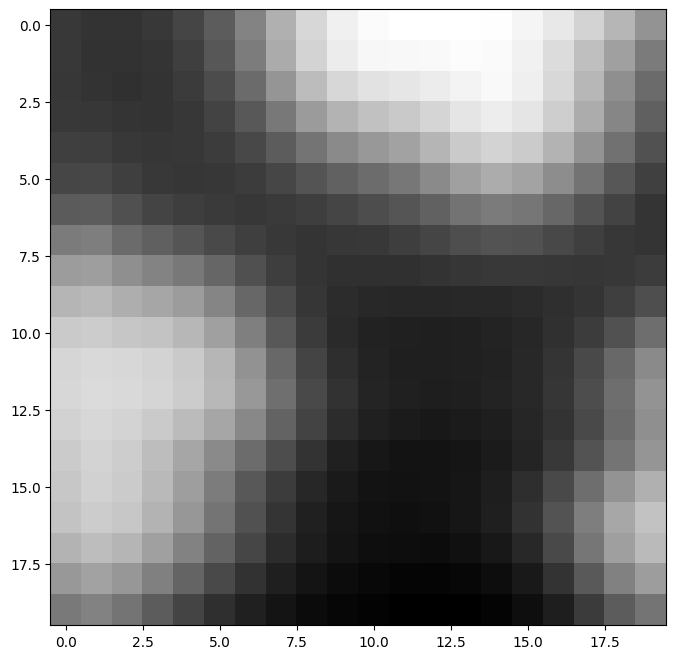

In [65]:
plt.imshow(feat_stmp[0])

In [64]:
pred=model.predict(feat_stmp)

61/61 [==============================] - 1s 16ms/step


In [66]:
pred.shape #ho numero immagini che ho passato=1936, numero neuroni in output=2

(1936, 2)

In [67]:
feat_stmp.shape

(1936, 20, 20, 1)

In [68]:
pimg=np.zeros(img.shape) #creo altra copia 
pimg[wid:nrow-wid,wid:ncol-wid]=pred[:,1].reshape(nrow-2*wid,ncol-2*wid)

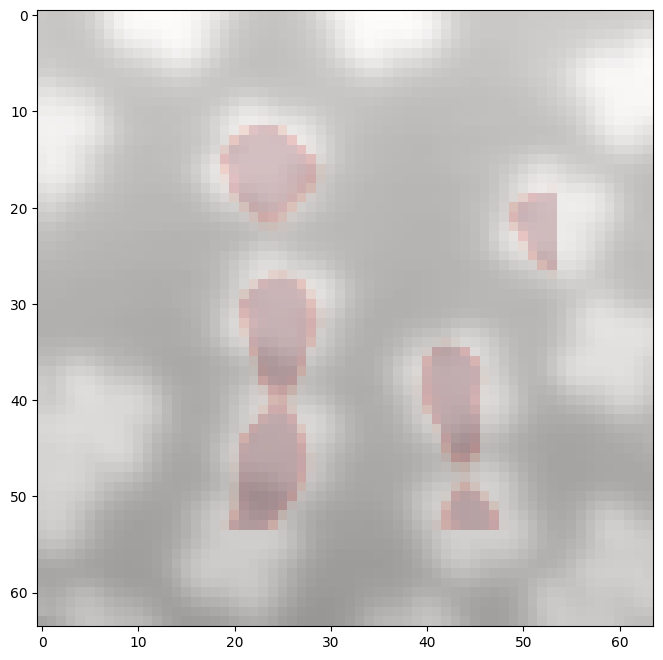

In [70]:
plt.imshow(img,alpha=0.5)
plt.imshow(pimg,cmap='Reds',alpha=0.2)

In [ ]:
#cioè ho trovato posizione cetntro abbastanza corretta tramite classificazione